In [2]:
from numpy import zeros, ones, asarray, expand_dims
from numpy.random import randn
from numpy.random import randint
from matplotlib import pyplot
from tensorflow.keras.datasets.fashion_mnist import load_data
import sys
sys.path.append("..")
from src.models.c_dcgan import GAN
from src.models.train_helpers import CGanTrainer

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

def load_real_samples():
    (trainX, trainy), (_, _) = load_data()
    X = expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5
    return [X, trainy]
 
def generate_real_samples(dataset, n_samples):
    images, labels = dataset
    ix = randint(0, images.shape[0], n_samples)
    X, labels = images[ix], labels[ix]
    y = ones((n_samples, 1))
    return [X, labels], y
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    trainer = CGanTrainer(d_model, g_model, gan_model, batch_size=128, n_classes=10, noise_dim=100)
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            trainer.train_step(X_real, labels_real)
    # save the generator model
        trainer.create_fig()
    g_model.save('cgan_generator.h5')

0.70297 0.6941575 0.6924201
0.6560704 0.6981631 0.6887767
0.5926018 0.7038851 0.68404484
0.55040014 0.7130325 0.67524064
0.51527476 0.7289064 0.66234004
0.46988562 0.75051177 0.64439785
0.4452327 0.78955793 0.61744785
0.41711617 0.8346117 0.59305733
0.4117548 0.86160755 0.58887
0.4097182 0.86223304 0.61255467
0.40244448 0.7989114 0.6673236
0.41346622 0.7207189 0.74757814
0.43698177 0.63555324 0.8188056
0.4438729 0.56766635 0.90847635
0.4195525 0.51324296 0.99989104
0.42091727 0.45411485 1.0890809
0.4445155 0.41465434 1.1577144
0.4396196 0.3736358 1.2571366
0.44567055 0.3402841 1.3280978
0.4722122 0.30869675 1.3875564
0.44776046 0.29859373 1.4513693
0.45843315 0.27434573 1.5208851
0.42259687 0.25102007 1.5858369
0.3329485 0.24026437 1.645262
0.4161932 0.2264646 1.6758829
0.3830837 0.20905906 1.7611973
0.37984198 0.1996046 1.8007375
0.36593026 0.19575956 1.8363171
0.3874976 0.18964398 1.8546896
0.45490375 0.18531811 1.8519127
0.32184747 0.17744803 1.89234
0.33333993 0.17363167 1.9415634


0.65961516 0.67472047 0.79510295
0.66041005 0.63861233 0.82242906
0.64926404 0.6534965 0.81880045
0.64601517 0.64438397 0.79933715
0.6408663 0.710276 0.789222
0.6047044 0.7071209 0.78153586
0.6583544 0.69492924 0.7408768
0.68902135 0.7227513 0.7498438
0.6654394 0.7253762 0.7681655
0.66379535 0.6999053 0.7423466
0.67218935 0.65220153 0.776618
0.6613797 0.6613349 0.83448416
0.67676187 0.6222322 0.8639128
0.6925731 0.58585835 0.8738917
0.7203947 0.6156038 0.88639903
0.67278004 0.6203855 0.8621146
0.6952424 0.6337229 0.83908534
0.7450608 0.6540223 0.8135095
0.7322372 0.6806368 0.74360013
0.6833954 0.7279378 0.73985714
0.7244195 0.7877296 0.7156914
0.69532424 0.78013945 0.69058704
0.72300935 0.7854135 0.6789639
0.7270341 0.75929433 0.7064478
0.73349416 0.78696245 0.6860175
0.77930737 0.72010434 0.7240821
0.73883986 0.6902901 0.79192626
0.73687255 0.6644726 0.81107616
0.711468 0.6477597 0.827675
0.7265723 0.61713755 0.82898813
0.7471026 0.63255495 0.83111537
0.7289089 0.62570703 0.781162
0.7

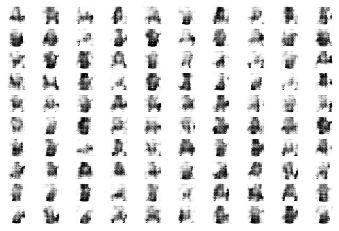

0.67332935 0.7506347 0.6634544
0.67972624 0.7546139 0.66840434
0.6911989 0.7769041 0.6570374
0.67920756 0.75585383 0.6635387
0.65467095 0.7498858 0.66766524
0.6606897 0.7230869 0.68925524
0.66443896 0.725911 0.6744479
0.65057206 0.72697544 0.6887131
0.6623398 0.72161555 0.692399
0.6509453 0.697317 0.69219506
0.66336447 0.7241212 0.6837299
0.66571236 0.7388239 0.6834028
0.6466837 0.7437924 0.6843634
0.6700753 0.7504897 0.6743673
0.65404093 0.758147 0.6527827
0.65014476 0.7768371 0.653379
0.6456363 0.7555692 0.6582656
0.6715118 0.76914203 0.6500375
0.6751313 0.7521643 0.6638146
0.6598921 0.73230743 0.67968833
0.68459904 0.7290927 0.6932264
0.667441 0.7168819 0.7082025
0.6729872 0.69483316 0.73456144
0.66441834 0.67405736 0.7270496
0.67217284 0.67069554 0.73670936
0.664858 0.6915542 0.73017204
0.66434073 0.68857855 0.723962
0.6597843 0.69941115 0.7118352
0.6469076 0.70760906 0.6946362
0.65198886 0.73185456 0.68466574
0.67208433 0.75596315 0.6732595
0.66233927 0.7491492 0.6661669
0.6940502

0.6852399 0.69518137 0.7025691
0.6626388 0.6956803 0.7133511
0.68222547 0.6834012 0.72765106
0.6724098 0.67940724 0.7463299
0.66525847 0.6436225 0.74268943
0.6683128 0.64833474 0.75020814
0.6807204 0.66469103 0.75836325
0.65974176 0.6888059 0.7336096
0.6572373 0.66362774 0.7299328
0.65398127 0.67577183 0.7455195
0.6587757 0.66549796 0.72497797
0.67422855 0.6895123 0.73433673
0.63308287 0.68875825 0.724674
0.66222566 0.69784045 0.71490586
0.63987684 0.70853984 0.70977813
0.64775324 0.7083648 0.725888
0.6805909 0.71943367 0.7056764
0.6488743 0.6959867 0.71505064
0.6696264 0.68277144 0.7272371
0.6632767 0.69711375 0.74478054
0.67930496 0.6705677 0.75595546
0.66971934 0.66078436 0.80583084
0.701221 0.6355872 0.8107662
0.66498065 0.6219207 0.79655623
0.72039884 0.6229286 0.8017627
0.7113573 0.6232507 0.816405
0.7182143 0.6195711 0.7792018
0.70053834 0.63567996 0.76613224
0.6977819 0.65550977 0.74780077
0.6815367 0.67666614 0.7422598
0.69626033 0.68476534 0.7241061
0.6503336 0.6791316 0.7130

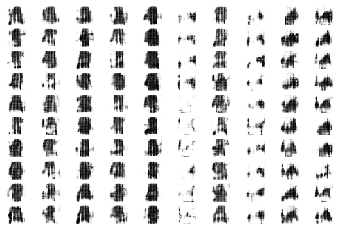

0.64771175 0.73867905 0.686903
0.6498895 0.72243845 0.6854921
0.66559935 0.73412466 0.67974246
0.65985143 0.7181515 0.67507046
0.6624608 0.7182589 0.6802107
0.65223384 0.7326098 0.69052935
0.6509802 0.7274128 0.6792726
0.64085454 0.7318703 0.68186593
0.64939725 0.7158874 0.6875427
0.6504977 0.724678 0.6901566
0.6785685 0.70891356 0.69652236
0.66143984 0.72224724 0.6970383
0.653092 0.7220889 0.6917758
0.6650139 0.71697545 0.70057905
0.6663367 0.7047979 0.6959361
0.66449827 0.7057463 0.697598
0.6824645 0.70550686 0.68929124
0.6486157 0.71349883 0.68661934
0.6636609 0.7221024 0.6984081
0.63858795 0.70681363 0.6864521
0.65225434 0.71746695 0.6923262
0.66909456 0.7094456 0.68194205
0.6534177 0.7321596 0.6740171
0.6660409 0.71548104 0.6890925
0.6597334 0.7084107 0.6991207
0.66057384 0.7128706 0.6954932
0.67535627 0.7150573 0.6926384
0.6829618 0.7307175 0.69281995


In [ ]:
latent_dim = 100    
# create the discriminator
gan = GAN((28,28,1))
d_model = gan.discriminator
# create the generator
g_model = gan.generator
# create the gan
gan_model = gan.combined
# load image data
dataset = load_real_samples()

# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    trainer = CGanTrainer(d_model, g_model, gan_model, batch_size=128, n_classes=10, noise_dim=100)
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            [images,labels],y = generate_real_samples(dataset, int(n_batch / 2))
            trainer.train_step(images,labels)

        # save the generator model
        create_fig(g_model)
    g_model.save('cgan_generator.h5')